# Real-time deep learning techniques for N-MRI image acquisition and motion removal

## Import the libraries

In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 1.73 ms (started: 2021-10-17 17:28:18 +00:00)


In [2]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
import gc
import time

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers, initializers
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import *

from PIL import Image

from tensorflow import keras
from keras import backend as K
from keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model, load_model
from keras.layers import Input, LeakyReLU, Concatenate
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.client import device_lib

from tensorflow.image import ssim as ssim
from tensorflow.image import psnr as snr
#!pip install scikit-learn
#from sklearn.metrics import mean_absolute_percentage_error as mpe

from google.colab import drive, files

print("Libraries correctly imported!")
print("Tensorflow version: \n", tf.__version__)
print("\nKeras version: \n", keras.__version__)

Libraries correctly imported!
Tensorflow version: 
 2.6.0

Keras version: 
 2.6.0
time: 2.37 s (started: 2021-10-17 17:28:18 +00:00)


## Enabling and Testing the GPU

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

print("\nList of available devices: \n")
device_lib.list_local_devices()

Found GPU at: /device:GPU:0

List of available devices: 



[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1086613515622168522, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11345264640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6359612585620654783
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

time: 5.66 s (started: 2021-10-17 17:28:20 +00:00)


## Import the Dataset

### Import from the web

In [ ]:
#!wget http://giagu.web.cern.ch/giagu/CERN/mri_motion_data_v1.tgz

##Extract the Dataset
#!tar xvzf mri_motion_data_v1.tgz

time: 1.92 ms (started: 2021-07-17 13:31:04 +00:00)


### Import from GoogleDrive

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 19.2 s (started: 2021-10-17 17:28:26 +00:00)


## Informations about the MRI scans

In [5]:
original_dataset_path = 'gdrive/MyDrive/dataset/original_mri'
corrupted_dataset_path = 'gdrive/MyDrive/dataset/corrupted_mri'

proxy_img = nib.load(original_dataset_path + '/img_0.nii.gz')
proxy_img_corr = nib.load(corrupted_dataset_path + '/img_motion_0.nii.gz')

img_hdr = proxy_img.header

img = proxy_img.get_fdata()
img_corr = proxy_img_corr.get_fdata()

proxy_img.uncache()
proxy_img_corr.uncache()

print("The scan shape is: \n", img.shape)
print("\n Data type: \n", type(img))
print("\n Number of dimensions: \n", img.ndim)
print("\n Type of data inside the array: \n", img.dtype)

#Central slices
x_center_value = img.shape[0]//2
y_center_value = img.shape[1]//2
z_center_value = img.shape[2]//2

#print("\n Image header: \n")
#print(img_hdr)

The scan shape is: 
 (180, 240, 241)

 Data type: 
 <class 'numpy.ndarray'>

 Number of dimensions: 
 3

 Type of data inside the array: 
 float64
time: 7.55 s (started: 2021-10-17 17:28:49 +00:00)


## Functions [1]

In [6]:
def flip(x):
  return np.rot90(x)

def load_orig_nifti_file(filepath):
  # Read the file
  scan = nib.load(original_dataset_path + '/' + filepath)
  scan.uncache()
  # Get the data
  scan = scan.get_fdata()
  return scan

def load_corr_nifti_file(filepath):
  # Read the file
  scan = nib.load(corrupted_dataset_path + '/' + filepath)
  scan.uncache()
  # Get the data
  scan = scan.get_fdata()
  return scan

def get_slices(scan, num_slices):
  slices = []
  if num_slices == 1:
    index = [0]
  elif num_slices == 3:
    index = [-1, 0, 1]
  elif num_slices == 5:
    index = [-2, -1, 0, 1, 2]
  else:
    print("Invalid number of slices!\n");
    return 
  for i in index:
    slice_x = flip(scan[x_center_value+i,:,:])
    slices.append(slice_x)
    slice_y = flip(scan[:,y_center_value+i,:])
    slices.append(slice_y)
    slice_z = flip(scan[:,:,z_center_value+i])
    slices.append(slice_z)
  return slices

def show_batch(batch, **kwargs):
  name = kwargs.get('name', None)
  plt.figure(figsize=(15, 15))
  i = 0
  for img in batch:
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tf.squeeze(img), cmap='gray')
    plt.axis("off")
    i+=1
  if name != None:
    plt.savefig(name+'.png')

time: 35.2 ms (started: 2021-10-17 17:28:56 +00:00)


## Example of original and corrupted image

Number of slices:  9

 Shape of slice-x: 

(241, 240)

 Shape of slice-y: 

(241, 180)

 Shape of slice-z: 

(240, 180)





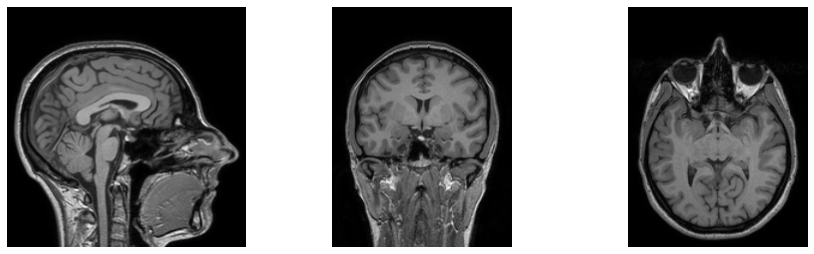

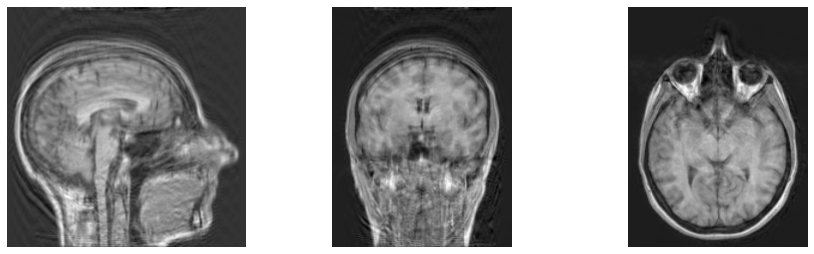

time: 600 ms (started: 2021-10-17 17:28:56 +00:00)


In [7]:
slices_orig = get_slices(img, 3)
slices_corr = get_slices(img_corr, 3)

print("Number of slices: ", len(slices_orig))

print("\n Shape of slice-x: \n")
print(slices_orig[0].shape)
print("\n Shape of slice-y: \n")
print(slices_orig[1].shape)
print("\n Shape of slice-z: \n")
print(slices_orig[2].shape)
print("\n\n")

show_batch(slices_orig[0:3])
show_batch(slices_corr[0:3])

## Functions [2]

### These functions create the datasets with a specific number of slices for each MRI scan. For each scan we take the N central slices for the 3 views (along x, y and z)

In [ ]:
def create_folders(path1, path2):
  isdir = os.path.isdir(path1)
  if isdir == False:
    os.mkdir(path1)
    print("Folder created!")
  isdir = os.path.isdir(path2)
  if isdir == False:
    os.mkdir(path2)
    print("Folder created!")
  
def split_range(num_slices, num_groups):
  tmp = range(num_slices)
  step = 3
  indices = range(num_groups)
  ranges = []
  index = 0
  for i in indices:
    ranges.append([tmp[index], tmp[index+1], tmp[index+2]])
    index += step
  return ranges

def save_img(i, j, ranges, folder_path, tmp, x_index, y_index, z_index):
  index = 0
  for range in ranges:
    if i in range:
      if i in x_index:
        tmp.save(folder_path+'/'+str(j)+'-'+str(index)+'-slice_x.png')
      elif i in y_index:
        tmp.save(folder_path+'/'+str(j)+'-'+str(index)+'-slice_y.png')
      elif i in z_index:
        tmp.save(folder_path+'/'+str(j)+'-'+str(index)+'-slice_z.png')
    else:
      index += 1

def create_sliced_original_datasets(num_slices, n_slices):
  path1_train = 'gdrive/MyDrive/train_original'
  path2_train = path1_train+'/train_sliced_original_mri'
  create_folders(path1_train, path2_train)
  path1_valid = 'gdrive/MyDrive/valid_original'
  path2_valid = path1_valid+'/valid_sliced_original_mri'
  create_folders(path1_valid, path2_valid)
  path1_test = 'gdrive/MyDrive/test_original'
  path2_test = path1_test+'/test_sliced_original_mri'
  create_folders(path1_test, path2_test)
  j = k = 1
  num_scans = len(os.listdir('gdrive/MyDrive/dataset/original_mri'))
  train_scans = round(0.8 * num_scans)
  other_scans = num_scans - train_scans
  valid_scans = round(0.9 * other_scans)
  index, x_index, y_index, z_index = [], [], [], []
  num_groups = int(n_slices/3)
  for i in range(num_groups):
    index.append(i)
  for i in index:
    x_index.append(i*3)  
  for i in x_index:
    y_index.append(i+1)
  for i in y_index:
    z_index.append(i+1)
  ranges = split_range(n_slices, num_groups)
  for filename in os.listdir(original_dataset_path):
    i = 0
    scan = load_orig_nifti_file(filename)
    slices = get_slices(scan, num_slices)
    for img in slices:
      img = 255*(img - np.min(img))/np.ptp(img)
      tmp = Image.fromarray(img.astype(np.uint8))
      if j <= train_scans:
        #Training scans
        save_img(i, j, ranges, path2_train, tmp, x_index, y_index, z_index)
      else:
        if k <= valid_scans:
          #Validation scans
          save_img(i, j, ranges, path2_valid, tmp, x_index, y_index, z_index)
        else:
          #Test scans
          save_img(i, j, ranges, path2_test, tmp, x_index, y_index, z_index)
      i+=1
    if j > train_scans:
      k+=1
    j+=1
  print("\n Training, Validation and Test 2D-Datasets with original slices created!")

def create_sliced_corrupted_datasets(num_slices, n_slices):
  path1_train = 'gdrive/MyDrive/train_corrupted'
  path2_train = path1_train+'/train_sliced_corrupted_mri'
  create_folders(path1_train, path2_train)
  path1_valid = 'gdrive/MyDrive/valid_corrupted'
  path2_valid = path1_valid+'/valid_sliced_corrupted_mri'
  create_folders(path1_valid, path2_valid)
  path1_test = 'gdrive/MyDrive/test_corrupted'
  path2_test = path1_test+'/test_sliced_corrupted_mri'
  create_folders(path1_test, path2_test)
  j = k = 1
  num_scans = len(os.listdir('gdrive/MyDrive/dataset/corrupted_mri'))
  train_scans = round(0.8 * num_scans)
  other_scans = num_scans - train_scans
  valid_scans = round(0.9 * other_scans)
  index, x_index, y_index, z_index = [], [], [], []
  num_groups = int(n_slices/3)
  for i in range(num_groups):
    index.append(i)
  for i in index:
    x_index.append(i*3)  
  for i in x_index:
    y_index.append(i+1)
  for i in y_index:
    z_index.append(i+1)
  ranges = split_range(n_slices, num_groups)
  for filename in os.listdir(corrupted_dataset_path):
    i = 0
    scan = load_corr_nifti_file(filename)
    slices = get_slices(scan, num_slices)
    for img in slices:
      img = 255*(img - np.min(img))/np.ptp(img)
      tmp = Image.fromarray(img.astype(np.uint8))
      if j <= train_scans:
        #Training scans
        save_img(i, j, ranges, path2_train, tmp, x_index, y_index, z_index)
      else:
        if k <= valid_scans:
          #Validation scans
          save_img(i, j, ranges, path2_valid, tmp, x_index, y_index, z_index)
        else:
          #Test scans
          save_img(i, j, ranges, path2_test, tmp, x_index, y_index, z_index)
      i+=1
    if j > train_scans:
      k+=1
    j+=1
  print("\n Training, Validation and Test 2D-Datasets with corrupted slices created!")

time: 204 ms (started: 2021-10-09 10:32:26 +00:00)


## Create the sliced datasets

### Execute this cell only if the datasets are not already present in Google Drive

In [ ]:
# num_slices can be equal to 1 or 3 or 5
# It's the number of slices per each view
num_slices = 1
tmp_slices = get_slices(img, num_slices)

# n_slices is the total number of slices
n_slices = len(tmp_slices)
print("Number of slices for each scan: ", n_slices)

create_sliced_original_datasets(num_slices, n_slices)
create_sliced_corrupted_datasets(num_slices, n_slices)

Number of slices for each scan:  3
Folder created!
Folder created!
Folder created!
Folder created!
Folder created!
Folder created!

 Training, Validation and Test 2D-Datasets with original slices created!
Folder created!
Folder created!
Folder created!
Folder created!
Folder created!
Folder created!

 Training, Validation and Test 2D-Datasets with corrupted slices created!
time: 38min 2s (started: 2021-10-09 10:33:00 +00:00)


## Dataset Generators

In [8]:
dataset_batch = 3
img_size = (240, 176)
class_mode = None
dataset = 'Datasets1'

time: 4.39 ms (started: 2021-10-17 17:28:57 +00:00)


### Train Dataset Generator

In [9]:
data_dir_corr = 'gdrive/MyDrive/'+dataset+'/train_corrupted'
data_dir_orig = 'gdrive/MyDrive/'+dataset+'/train_original'
corr_train_samples = len(os.listdir(data_dir_corr+'/train_sliced_corrupted_mri'))
orig_train_samples = len(os.listdir(data_dir_orig+'/train_sliced_original_mri'))

train_datagen = ImageDataGenerator(
    rescale = 1/255.
)

train_corr_ds = train_datagen.flow_from_directory(
    data_dir_corr,
    target_size = img_size,
    color_mode = 'grayscale',
    batch_size = dataset_batch,
    class_mode = class_mode,
    shuffle = False,
    seed = 123
)

train_orig_ds = train_datagen.flow_from_directory(
    data_dir_orig,
    target_size = img_size,
    color_mode = 'grayscale',
    batch_size = dataset_batch,
    class_mode = class_mode,
    shuffle = False,
    seed = 123
)

print("\nNumber of corrupted train samples: \n", corr_train_samples)
print("\nNumber of original train samples: \n", orig_train_samples)
print("\nCorrupted Train Dataset: \n", train_corr_ds)
print("\nOriginal Train Dataset: \n", train_orig_ds)
print("\nLenght of corrupted train dataset: \n", len(train_corr_ds))
print("\nLenght of original train dataset: \n", len(train_orig_ds))

Found 1383 images belonging to 1 classes.
Found 1383 images belonging to 1 classes.

Number of corrupted train samples: 
 1383

Number of original train samples: 
 1383

Corrupted Train Dataset: 

Original Train Dataset: 

Lenght of corrupted train dataset: 
 461

Lenght of original train dataset: 
 461
time: 12.9 s (started: 2021-10-17 17:28:58 +00:00)


### Validation Dataset Generator

In [10]:
data_dir_corr = 'gdrive/MyDrive/'+dataset+'/valid_corrupted'
data_dir_orig = 'gdrive/MyDrive/'+dataset+'/valid_original'
corr_valid_samples = len(os.listdir(data_dir_corr+'/valid_sliced_corrupted_mri'))
orig_valid_samples = len(os.listdir(data_dir_orig+'/valid_sliced_original_mri'))

valid_datagen = ImageDataGenerator(
    rescale = 1/255.
)

valid_corr_ds = valid_datagen.flow_from_directory(
    data_dir_corr,
    target_size = img_size,
    color_mode = 'grayscale',
    batch_size = dataset_batch,
    class_mode = None,
    shuffle = False,
    seed = 123
)

valid_orig_ds = valid_datagen.flow_from_directory(
    data_dir_orig,
    target_size = img_size,
    color_mode = 'grayscale',
    batch_size = dataset_batch,
    class_mode = None,
    shuffle = False,
    seed = 123
)

print("\nNumber of corrupted validation samples: \n", corr_valid_samples)
print("\nNumber of original validation samples: \n", orig_valid_samples)
print("\nCorrupted Validation Dataset: \n", valid_corr_ds)
print("\nOriginal Validation Dataset: \n", valid_orig_ds)
print("\nLenght of corrupted validation dataset: \n", len(valid_corr_ds))
print("\nLenght of original validation dataset: \n", len(valid_orig_ds))

Found 312 images belonging to 1 classes.
Found 312 images belonging to 1 classes.

Number of corrupted validation samples: 
 312

Number of original validation samples: 
 312

Corrupted Validation Dataset: 

Original Validation Dataset: 

Lenght of corrupted validation dataset: 
 104

Lenght of original validation dataset: 
 104
time: 3.4 s (started: 2021-10-17 17:29:11 +00:00)


### Test Dataset Generator

In [11]:
data_dir_corr = 'gdrive/MyDrive/'+dataset+'/test_corrupted'
data_dir_orig = 'gdrive/MyDrive/'+dataset+'/test_original'
corr_test_samples = len(os.listdir(data_dir_corr+'/test_sliced_corrupted_mri'))
orig_test_samples = len(os.listdir(data_dir_orig+'/test_sliced_original_mri'))

test_datagen = ImageDataGenerator(
    rescale = 1/255.
)

test_corr_ds = test_datagen.flow_from_directory(
    data_dir_corr,
    target_size = img_size,
    color_mode = 'grayscale',
    batch_size = dataset_batch,
    class_mode = class_mode,
    shuffle = False,
    seed = 123
)

test_orig_ds = test_datagen.flow_from_directory(
    data_dir_orig,
    target_size = img_size,
    color_mode = 'grayscale',
    batch_size = dataset_batch,
    class_mode = None,
    shuffle = False,
    seed = 123
)

print("\nNumber of corrupted test samples: \n", corr_test_samples)
print("\nNumber of original test samples: \n", orig_test_samples)
print("\nCorrupted test Dataset: \n", test_corr_ds)
print("\nOriginal test Dataset: \n", test_orig_ds)
print("\nLenght of corrupted test dataset: \n", len(test_corr_ds))
print("\nLenght of original test dataset: \n", len(test_orig_ds))

Found 33 images belonging to 1 classes.
Found 33 images belonging to 1 classes.

Number of corrupted test samples: 
 33

Number of original test samples: 
 33

Corrupted test Dataset: 

Original test Dataset: 

Lenght of corrupted test dataset: 
 11

Lenght of original test dataset: 
 11
time: 1.04 s (started: 2021-10-17 17:29:14 +00:00)


### Example of image batches in the new datasets

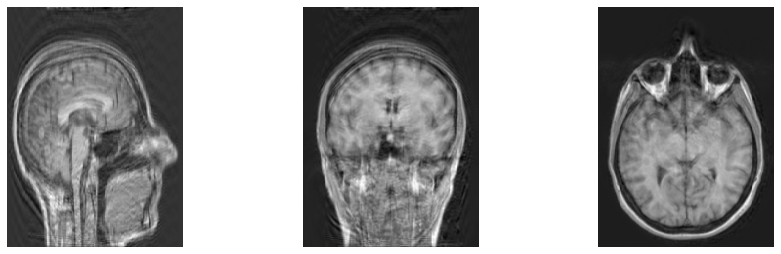

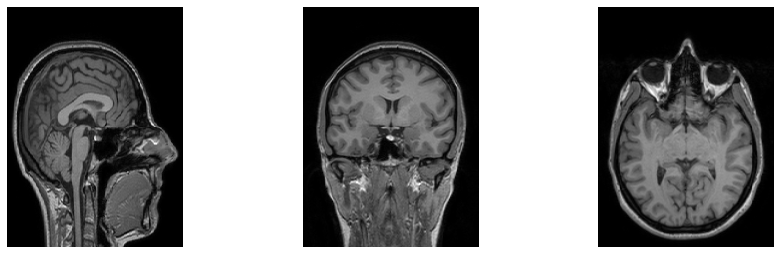

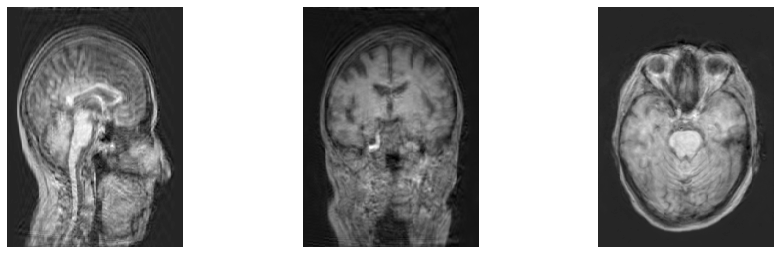

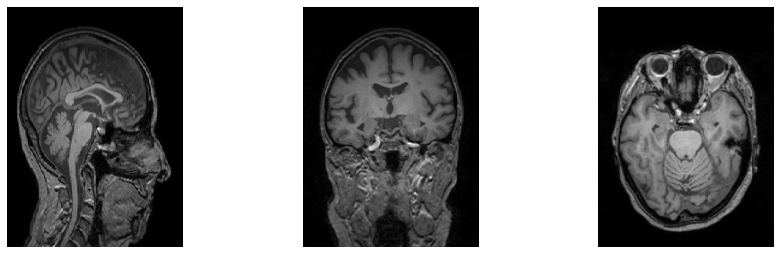

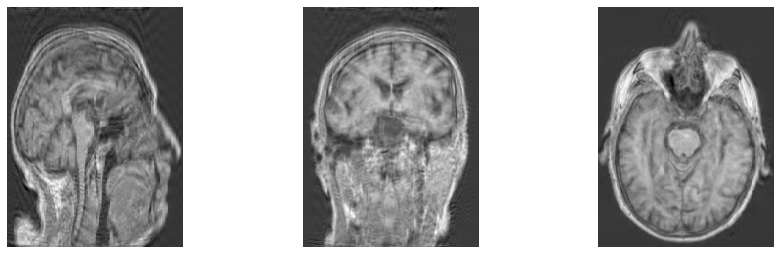

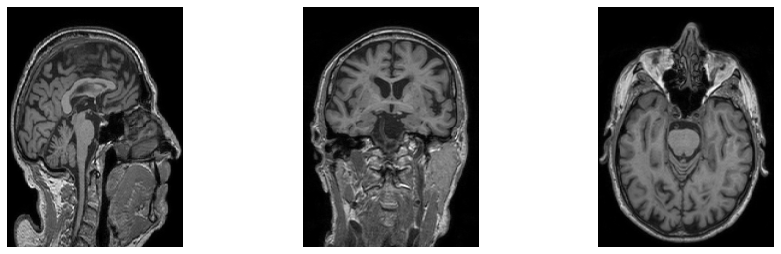

time: 5 s (started: 2021-10-17 17:29:15 +00:00)


In [12]:
train_corr_batch = train_corr_ds[0]
train_orig_batch = train_orig_ds[0]
valid_corr_batch = valid_corr_ds[0]
valid_orig_batch = valid_orig_ds[0]
test_corr_batch = test_corr_ds[0]
test_orig_batch = test_orig_ds[0]

#Train Corrupted Dataset
show_batch(train_corr_batch, name='train_corr')

#Train Original Dataset
show_batch(train_orig_batch, name='train_orig')

#Validation Corrupted Dataset
show_batch(valid_corr_batch)

#Validation Original Dataset
show_batch(valid_orig_batch)

#Test Corrupted Dataset
show_batch(test_corr_batch)

#Test Original Dataset
show_batch(test_orig_batch)

### Combine Generators

In [13]:
def combine_generator(gen1, gen2):
    while True:
        yield(next(gen1), next(gen2))

train_gen = combine_generator(train_corr_ds, train_orig_ds)
valid_gen = combine_generator(valid_corr_ds, valid_orig_ds)

time: 3.5 ms (started: 2021-10-17 17:29:20 +00:00)


## Model Architecture

In [14]:
reg_value = 1e-4

initializer = initializers.glorot_normal()
regularizer = None
kernel_size = (3,3)
img_shape = (240, 176, 1)

time: 2.72 ms (started: 2021-10-17 17:29:20 +00:00)


### Functions [3]

In [15]:
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
      gc.collect()

class WriteReport(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    with open(report_path, 'a') as writefile:
        writefile.write('Epoch: {}  Loss: {:7.6f} SSIM: {:7.6f} Val_Loss: {:7.6f} Val_SSIM: {:7.6f} \n'
          .format(epoch, logs['loss'], logs['ssim_metric'], logs['val_loss'], logs['val_ssim_metric']))
  
  def on_train_end(self, logs=None):
    if isfile:
      with open(report_path, 'a') as writefile:
        writefile.write('END TRAINING!\n')


#The scalar metric value you are tracking during training and evaluation is 
#the average of the per-batch metric values for all batches see during a given epoch
def ssim_metric(y_true, y_pred):
  SSIM = ssim(y_pred, y_true, max_val=1.0)
  return SSIM

def L1_loss(y_true, y_pred): 
    return tf.reduce_sum(tf.abs(y_true-y_pred))

def L2_loss(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_true-y_pred))

def mean_squared_error(img1, img2):
  loss = K.mean(K.square(img1 - img2))
  return loss

########################### PERCEPTUAL LOSS ###################################
selected_layers = [0, 1, 2]
selected_layer_weights = [0.65, 0.3, 0.05]

vgg = VGG16(weights='imagenet', include_top=False, input_shape=(240, 176, 3))
vgg.trainable = False
outputs = [vgg.layers[i].output for i in selected_layers]
lossModel = Model(vgg.input, outputs)

lossModel.trainable = False
for layer in lossModel.layers:
    layer.trainable=False

@tf.function
def perceptual_loss(input_image, reconstruct_image):
    orig_img = Concatenate()([input_image, input_image, input_image])
    corrected_img = Concatenate()([reconstruct_image, reconstruct_image, reconstruct_image])
    h1_list = lossModel(orig_img)
    h2_list = lossModel(corrected_img)

    rc_loss = 0.0
    for h1, h2, weight in zip(h1_list, h2_list, selected_layer_weights):
        #h1 = K.batch_flatten(h1)
        #h2 = K.batch_flatten(h2)
        rc_loss = rc_loss + weight * K.sqrt(K.mean(K.square(h1 - h2)))

    return rc_loss

58900480/58889256 [==============================] - 1s 0us/step
time: 1.33 s (started: 2021-10-17 17:29:20 +00:00)


### Autoencoder

#### Functions [4]

##### These functions create the encoder and decoder blocks for the model

In [16]:
def create_encoder(input_shape, n, name):
  input = keras.Input(shape = input_shape)
  x = Conv2D(n, kernel_size, strides=2, padding='same',
             kernel_initializer=initializer, kernel_regularizer=regularizer)(input)
  x = BatchNormalization()(x)
  layer1_output = Activation('relu')(x)
  x = Conv2D(n, kernel_size, strides=1, padding='same',
             kernel_initializer=initializer, kernel_regularizer=regularizer)(layer1_output)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(n/2, kernel_size, strides=1, padding='same',
             kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(n, kernel_size, strides=1, padding='same',
             kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = layers.add([x, layer1_output])
  x = Conv2D(n, kernel_size, strides=1, padding='same',
             kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
  x = BatchNormalization()(x)
  encoder_output = Activation('relu')(x)
  model = Model(inputs=input, outputs=encoder_output, name=name)
  return model

def create_decoder(input_shape, n, name):
  input = keras.Input(shape = input_shape)
  x = Conv2DTranspose(n, kernel_size, strides=1, padding='same',
                      kernel_initializer=initializer, kernel_regularizer=regularizer)(input)
  x = BatchNormalization()(x)
  layer1_output = Activation('relu')(x)
  layer1_output = Dropout(0.2)(x)
  x = Conv2DTranspose(n, kernel_size, strides=1, padding='same',
                      kernel_initializer=initializer, kernel_regularizer=regularizer)(layer1_output)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.2)(x)
  x = Conv2DTranspose(n/2, kernel_size, strides=1, padding='same',
                      kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.2)(x)
  x = Conv2DTranspose(n, kernel_size, strides=1, padding='same',
                      kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.2)(x)
  x = layers.add([x, layer1_output])
  x = Conv2DTranspose(n, kernel_size, strides=2, padding='same',
                      kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
  x = BatchNormalization()(x)
  decoder_output = Activation('relu')(x)
  decoder_output = Dropout(0.2)(x)
  model = Model(inputs=input, outputs=decoder_output, name=name)
  return model

time: 62.2 ms (started: 2021-10-17 17:29:22 +00:00)


#### Creating encoders and decoders

In [17]:
img_shape = (240, 176, 1)
#Encoders: 32 64 128 256  #Decoders: 128 64 32 32
#Hidden layers: 
# encoder1 = decoder3 / encoder2 = decoder2 / encoder3 = decoder1
n1 = 32
n2 = 64
n3 = 128
n4 = 256
n5 = 32

input = keras.Input(shape=img_shape, name='corrupted_img')
encoder1 = create_encoder(img_shape, n1, 'encoder1')
encoder2 = create_encoder(encoder1.output.shape[1:], n2, 'encoder2')
encoder3 = create_encoder(encoder2.output.shape[1:], n3, 'encoder3')
encoder4 = create_encoder(encoder3.output.shape[1:], n4, 'encoder4')

decoder1 = create_decoder(encoder4.output.shape[1:], n3, 'decoder1')
decoder2 = create_decoder(decoder1.output.shape[1:], n2, 'decoder2')
decoder3 = create_decoder(decoder2.output.shape[1:], n1, 'decoder3')
decoder4 = create_decoder(decoder3.output.shape[1:], n5, 'decoder4')

time: 1.08 s (started: 2021-10-17 17:29:22 +00:00)


#### Creation of the autoencoder model

In [18]:
def create_autoencoder():
  input = keras.Input(shape=img_shape, name='corrupted_img')
  output1 = encoder1(input)
  output2 = encoder2(output1)
  output3 = encoder3(output2)
  output4 = encoder4(output3)

  output5 = decoder1(output4)
  tmp = layers.add([output5, output3])
  output6 = decoder2(tmp)
  tmp = layers.add([output6, output2])
  output7 = decoder3(tmp)
  tmp = layers.add([output7, output1])
  output8 = decoder4(tmp)
  autoencoder_output = Conv2D(1, (1,1), strides=1, padding='same', 
                              kernel_initializer=initializer, 
                              kernel_regularizer=regularizer,
                              activation='sigmoid')(output8)

  model = Model(input, autoencoder_output, name = 'autoencoder')
  return model

model = create_autoencoder()
initial_weights = model.get_weights()

time: 731 ms (started: 2021-10-17 17:29:23 +00:00)


## Model Training

### Summary and plot

In [19]:
model.summary()

#keras.utils.plot_model(encoder1)

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
corrupted_img (InputLayer)      [(None, 240, 176, 1) 0                                            
__________________________________________________________________________________________________
encoder1 (Functional)           (None, 120, 88, 32)  28656       corrupted_img[0][0]              
__________________________________________________________________________________________________
encoder2 (Functional)           (None, 60, 44, 64)   130464      encoder1[0][0]                   
__________________________________________________________________________________________________
encoder3 (Functional)           (None, 30, 22, 128)  518976      encoder2[0][0]                   
________________________________________________________________________________________

### Model compile

In [20]:
learning_rate = 0.0001

########### EXPONENTIAL DECAY ##################################
initial_learning_rate = 0.0001
decay_steps = 70000
decay_rate = 0.96
#learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=decay_steps,
#    decay_rate=decay_rate,
#    staircase=True)

train_batch = 1

steps_per_epoch = len(train_orig_ds)/train_batch
validation_steps = len(valid_orig_ds)/train_batch
print("Steps per epoch: \n", int(steps_per_epoch))

optimizer = optimizers.RMSprop(learning_rate)

model.compile(
    optimizer = optimizer,
    loss = 'mean_squared_error',
    #loss = perceptual_loss,
    metrics = [ssim_metric]
)

Steps per epoch: 
 461
time: 23 ms (started: 2021-10-17 17:29:24 +00:00)


### Create folder and Callbacks

In [21]:
if isinstance(optimizer, optimizers.RMSprop):
  optimizer_name = 'RMSProp'
elif isinstance(optimizer, optimizers.Adam):
  optimizer_name = 'Adam'

if model.name == 'autoencoder':
  model_folder = 'AE'
elif model.name == 'cnn':
  model_folder = 'CNN'
elif model.name == 'resnet':
  model_folder = 'ResNet'

if isinstance(learning_rate, optimizers.schedules.ExponentialDecay):
  learning_rate = 'ExpDecay(In:'+str(initial_learning_rate)+'-Decay_Steps:'\
                  +str(decay_steps)+'-Decay_Rate:'+str(decay_rate)

if regularizer == None:
  reg_value = 0

if model.loss == 'mean_squared_error':
  loss_name = 'MSE'
elif model.loss == 'binary_crossentropy':
  loss_name = 'BinaryCross'
elif model.loss.__name__ == 'L1_loss':
  loss_name = 'L1'
elif model.loss.__name__ == 'L2_loss':
  loss_name = 'L2'
elif model.loss.__name__ == 'perceptual_loss':
  loss_name = 'Perceptual'

path = 'gdrive/MyDrive/Test/'+model_folder+'/'+dataset+'-LR='+str(learning_rate)+\
        '-DatasetBatch='+str(dataset_batch)+'-TrainBatch='+str(train_batch)+\
        '-Opt='+optimizer_name+'-Loss='+loss_name+'-Reg='+str(reg_value)
isdir = os.path.isdir(path)
if isdir==False:
  os.mkdir(path)
report_path = path+'/training_report.txt'
isfile = os.path.isfile(report_path)
if isfile==False:
  f = open(report_path, 'w+')

weights_path = path+'/weights.h5'
last_weights_path = path+'/last_weights.h5'

callbacks = [GarbageCollectorCallback(),
             ModelCheckpoint(weights_path, 
                             save_best_only = True, save_freq='epoch',
                             monitor='val_loss', save_weights_only = True, mode='min'),
             ModelCheckpoint(last_weights_path, 
                             save_best_only = False, save_freq='epoch',
                             monitor='val_loss', save_weights_only = True, mode='min'),
             WriteReport()]

time: 471 ms (started: 2021-10-17 17:29:24 +00:00)


### Set/Load initial weights

In [22]:
#model.set_weights(initial_weights)

#Load weights from an existing file
model.load_weights(last_weights_path)

time: 3.32 s (started: 2021-10-17 17:29:24 +00:00)


### Training

In [ ]:
epochs = 15

with tf.device(device_name):
  history = model.fit(train_gen, validation_data=valid_gen,
                      steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, 
                      batch_size=train_batch, epochs=epochs, callbacks=callbacks)

## Test the model

#### In this section we compare the output of the model, feeded with a corrupted unseen image, to the corresponding original image

#### Apply the model on the test and training set

In [24]:
corrected_test_ds = []
corrected_train_ds = []
i = 0

for i in range(len(test_corr_ds)):
  corrected_batch = model(test_corr_ds[i])
  corrected_test_ds.append(corrected_batch)

for i in range(len(train_corr_ds)):
  corrected_batch = model(train_corr_ds[i])
  corrected_train_ds.append(corrected_batch)

time: 47.1 s (started: 2021-10-17 17:55:14 +00:00)


### Image results

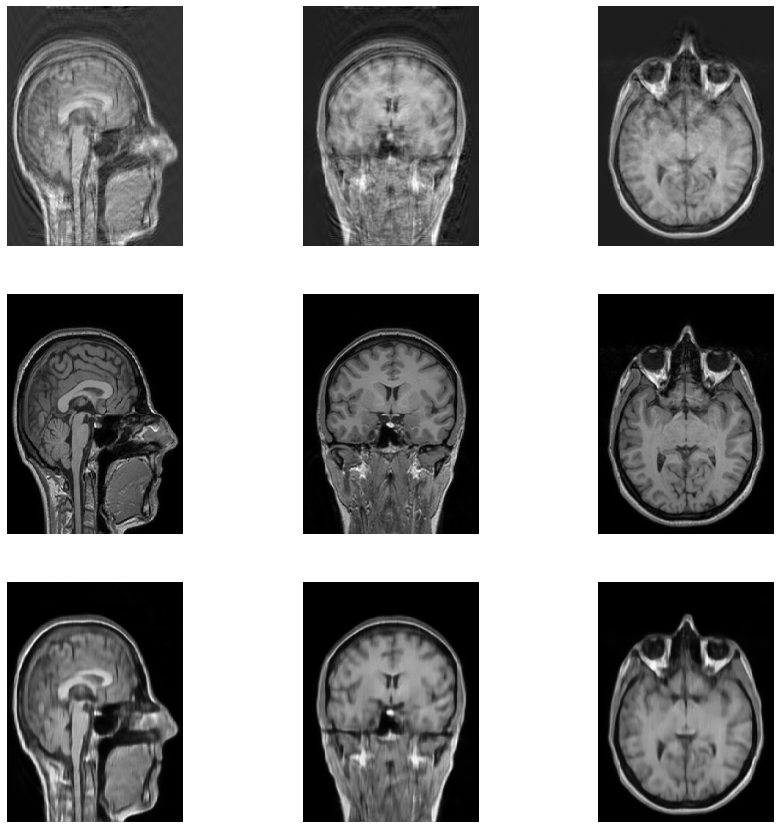

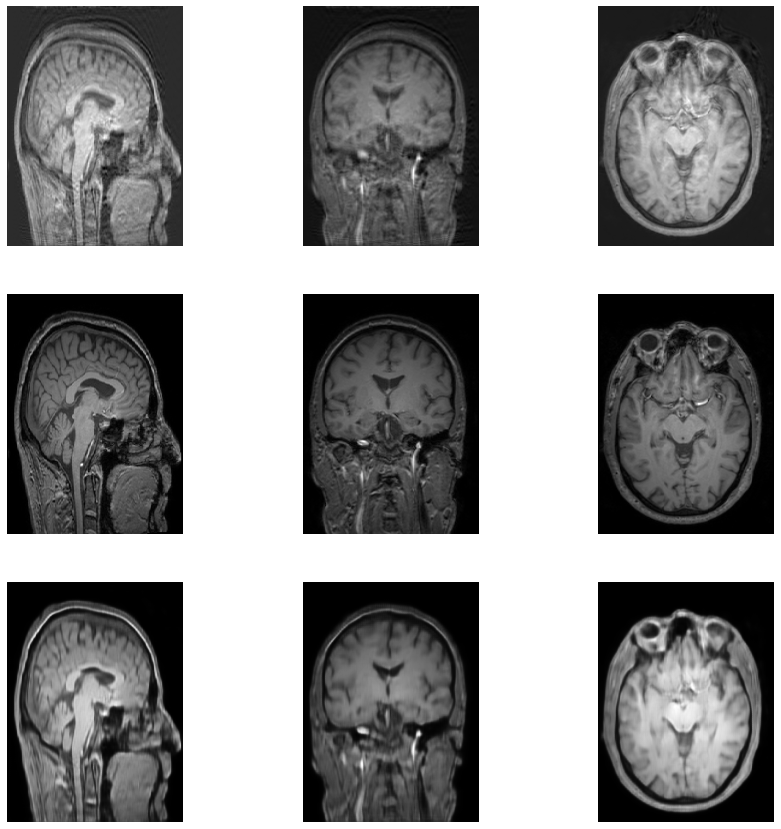

time: 2.95 s (started: 2021-10-17 17:56:01 +00:00)


In [25]:
train_corr_batch = train_corr_ds[0]
train_orig_batch = train_orig_ds[0]
corrected_train_img = model(train_corr_batch)

batch = np.concatenate((train_corr_batch, train_orig_batch, corrected_train_img))
show_batch(batch, name='train')

test_corr_batch = test_corr_ds[3]
test_orig_batch = test_orig_ds[3]
corrected_test_img = model(test_corr_batch)

batch = np.concatenate((test_corr_batch, test_orig_batch, corrected_test_img))
show_batch(batch, name='test')

### Save slices

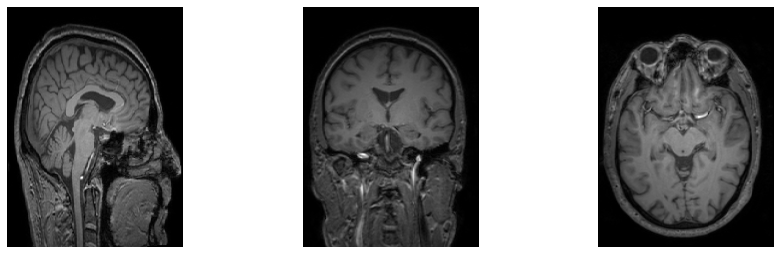

time: 487 ms (started: 2021-10-17 17:56:04 +00:00)


In [26]:
def save_single_slices(batch):
  i = 0
  fig = plt.figure(figsize=(15, 15))
  for img in batch:
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tf.squeeze(img), cmap='gray')
    plt.axis("off")

    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    i += 1
    fig.savefig(str(i)+'.png', bbox_inches=extent)
   
save_single_slices(test_orig_batch)

### Metrics results

#### Functions [5]

In [34]:
######## MEAN SQUARED ERROR ###############################
def mse_tot(dataset1, dataset2):
  #The first dataset should be the corrupted/corrected one
  #The second dataset should be the original one
  i = 0
  n_axis = len(dataset1)
  n_tot = 3*n_axis

  mse_tot = 0
  mse_tot_x = 0
  mse_tot_y = 0
  mse_tot_z = 0

  for i in range(len(dataset1)):
    corr_batch = dataset1[i]
    orig_batch = dataset2[i]

    tmp_mse_x = mean_squared_error(corr_batch[0], orig_batch[0]).numpy()
    tmp_mse_y = mean_squared_error(corr_batch[1], orig_batch[1]).numpy()
    tmp_mse_z = mean_squared_error(corr_batch[2], orig_batch[2]).numpy()

    mse_tot_x = mse_tot_x + tmp_mse_x
    mse_tot_y = mse_tot_y + tmp_mse_y
    mse_tot_z = mse_tot_z + tmp_mse_z
    sum = tmp_mse_x + tmp_mse_y + tmp_mse_z
    mse_tot = mse_tot + sum
  
  mse_tot_x = mse_tot_x / n_axis
  mse_tot_y = mse_tot_y / n_axis
  mse_tot_z = mse_tot_z / n_axis
  mse_tot = mse_tot / n_tot
  
  return mse_tot_x, mse_tot_y, mse_tot_z, mse_tot

######## STRUCTURAL SIMILARITY INDEX ###############################
def ssim_tot(dataset1, dataset2):
  #The first dataset should be the corrupted/corrected one
  #The second dataset should be the original one
  i = 0
  n_axis = len(dataset1)
  n_tot = 3*n_axis

  ssim_tot = 0
  ssim_tot_x = 0
  ssim_tot_y = 0
  ssim_tot_z = 0

  for i in range(len(dataset1)):
    corr_batch = dataset1[i]
    orig_batch = dataset2[i]

    tmp_ssim = ssim(corr_batch, orig_batch, max_val=1.0).numpy()

    tmp_ssim_x = tmp_ssim[0]
    tmp_ssim_y = tmp_ssim[1]
    tmp_ssim_z = tmp_ssim[2]

    ssim_tot_x = ssim_tot_x + tmp_ssim_x
    ssim_tot_y = ssim_tot_y + tmp_ssim_y
    ssim_tot_z = ssim_tot_z + tmp_ssim_z
    sum = tmp_ssim_x + tmp_ssim_y + tmp_ssim_z
    ssim_tot = ssim_tot + sum
  
  ssim_tot_x = ssim_tot_x / n_axis
  ssim_tot_y = ssim_tot_y / n_axis
  ssim_tot_z = ssim_tot_z / n_axis
  ssim_tot = ssim_tot / n_tot
  
  return ssim_tot_x, ssim_tot_y, ssim_tot_z, ssim_tot

######## SIGNAL-TO-NOISE RATIO ###############################
def snr_tot(dataset1, dataset2):
  #The first dataset should be the corrupted/corrected one
  #The second dataset should be the original one
  i = 0
  n_axis = len(dataset1)
  n_tot = 3*n_axis

  snr_tot = 0
  snr_tot_x = 0
  snr_tot_y = 0
  snr_tot_z = 0

  for i in range(len(dataset1)):
    corr_batch = dataset1[i]
    orig_batch = dataset2[i]

    tmp_snr = snr(corr_batch, orig_batch, max_val=1.0).numpy()

    tmp_snr_x = tmp_snr[0]
    tmp_snr_y = tmp_snr[1]
    tmp_snr_z = tmp_snr[2]

    snr_tot_x = snr_tot_x + tmp_snr_x
    snr_tot_y = snr_tot_y + tmp_snr_y
    snr_tot_z = snr_tot_z + tmp_snr_z
    sum = tmp_snr_x + tmp_snr_y + tmp_snr_z
    snr_tot = snr_tot + sum
  
  snr_tot_x = snr_tot_x / n_axis
  snr_tot_y = snr_tot_y / n_axis
  snr_tot_z = snr_tot_z / n_axis
  snr_tot = snr_tot / n_tot
  
  return snr_tot_x, snr_tot_y, snr_tot_z, snr_tot

######## MEAN PERCENTAGE ERROR ###############################
def mape(y_pred, y_true): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))*100

def mape_tot(dataset1, dataset2):
  #The first dataset should be the corrupted/corrected one
  #The second dataset should be the original one
  i = 0
  n_axis = len(dataset1)
  n_tot = 3*n_axis

  mape_tot = 0
  mape_tot_x = 0
  mape_tot_y = 0
  mape_tot_z = 0

  for i in range(len(dataset1)):
    corr_batch = dataset1[i]
    orig_batch = dataset2[i]

    tmp_mape_x = mape(corr_batch[0], orig_batch[0])
    tmp_mape_y = mape(corr_batch[1], orig_batch[1])
    tmp_mape_z = mape(corr_batch[2], orig_batch[2])

    mape_tot_x = mape_tot_x + tmp_mape_x
    mape_tot_y = mape_tot_y + tmp_mape_y
    mape_tot_z = mape_tot_z + tmp_mape_z
    sum = tmp_mape_x + tmp_mape_y + tmp_mape_z
    mape_tot = mape_tot + sum
  
  mape_tot_x = mape_tot_x / n_axis
  mape_tot_y = mape_tot_y / n_axis
  mape_tot_z = mape_tot_z / n_axis
  mape_tot = mape_tot / n_tot
  
  return mape_tot_x, mape_tot_y, mape_tot_z, mape_tot

time: 193 ms (started: 2021-10-17 18:06:48 +00:00)


#### Mean Squared Error

In [28]:
mse_test_corrupted_x, mse_test_corrupted_y, mse_test_corrupted_z, mse_test_corrupted = mse_tot(test_corr_ds, test_orig_ds)
mse_test_corrected_x, mse_test_corrected_y, mse_test_corrected_z, mse_test_corrected = mse_tot(corrected_test_ds, test_orig_ds)

mse_train_corrupted_x, mse_train_corrupted_y, mse_train_corrupted_z, mse_train_corrupted = mse_tot(train_corr_ds, train_orig_ds)
mse_train_corrected_x, mse_train_corrected_y, mse_train_corrected_z, mse_train_corrected = mse_tot(corrected_train_ds, train_orig_ds)

print('MEAN SQUARED ERROR OF THE TRAIN SET\n\n')
print('MSE corrupted / original:')
print('- MSE along x-axis: ', mse_train_corrupted_x)
print('- MSE along y-axis: ', mse_train_corrupted_y)
print('- MSE along z-axis: ', mse_train_corrupted_z)
print('- Total MSE: ', mse_train_corrupted)

print('\nMSE corrected / original:')
print('- MSE along x-axis: ', mse_train_corrected_x)
print('- MSE along y-axis: ', mse_train_corrected_y)
print('- MSE along z-axis: ', mse_train_corrected_z)
print('- Total MSE: ', mse_train_corrected)

print('\n\nMEAN SQUARED ERROR OF THE TEST SET\n\n')
print('MSE corrupted / original:')
print('- MSE along x-axis: ', mse_test_corrupted_x)
print('- MSE along y-axis: ', mse_test_corrupted_y)
print('- MSE along z-axis: ', mse_test_corrupted_z)
print('- Total MSE: ', mse_test_corrupted)

print('\nMSE corrected / original:')
print('- MSE along x-axis: ', mse_test_corrected_x)
print('- MSE along y-axis: ', mse_test_corrected_y)
print('- MSE along z-axis: ', mse_test_corrected_z)
print('- Total MSE: ', mse_test_corrected)

MEAN SQUARED ERROR OF THE TRAIN SET


MSE corrupted / original:
- MSE along x-axis:  0.027980591064428108
- MSE along y-axis:  0.025622995463230217
- MSE along z-axis:  0.016593640799979617
- Total MSE:  0.02339907576661996

MSE corrected / original:
- MSE along x-axis:  0.002694796630658145
- MSE along y-axis:  0.00255168508662521
- MSE along z-axis:  0.0022833126447104938
- Total MSE:  0.0025099314431392536


MEAN SQUARED ERROR OF THE TEST SET


MSE corrupted / original:
- MSE along x-axis:  0.02839561788873239
- MSE along y-axis:  0.02536037073216655
- MSE along z-axis:  0.023159384685145182
- Total MSE:  0.02563845750057336

MSE corrected / original:
- MSE along x-axis:  0.003814002393152226
- MSE along y-axis:  0.0033975920470600777
- MSE along z-axis:  0.004832261771133
- Total MSE:  0.004014618694782257
time: 20.2 s (started: 2021-10-17 17:56:05 +00:00)


#### SSIM

In [29]:
ssim_test_corrupted_x, ssim_test_corrupted_y, ssim_test_corrupted_z, ssim_test_corrupted = ssim_tot(test_corr_ds, test_orig_ds)
ssim_test_corrected_x, ssim_test_corrected_y, ssim_test_corrected_z, ssim_test_corrected = ssim_tot(corrected_test_ds, test_orig_ds)

ssim_train_corrupted_x, ssim_train_corrupted_y, ssim_train_corrupted_z, ssim_train_corrupted = ssim_tot(train_corr_ds, train_orig_ds)
ssim_train_corrected_x, ssim_train_corrected_y, ssim_train_corrected_z, ssim_train_corrected = ssim_tot(corrected_train_ds, train_orig_ds)

print('SSIM OF THE TRAIN SET\n\n')
print('SSIM corrupted / original:')
print('- SSIM along x-axis: ', ssim_train_corrupted_x)
print('- SSIM along y-axis: ', ssim_train_corrupted_y)
print('- SSIM along z-axis: ', ssim_train_corrupted_z)
print('- Total SSIM: ', ssim_train_corrupted)

print('\nSSIM corrected / original:')
print('- SSIM along x-axis: ', ssim_train_corrected_x)
print('- SSIM along y-axis: ', ssim_train_corrected_y)
print('- SSIM along z-axis: ', ssim_train_corrected_z)
print('- Total SSIM: ', ssim_train_corrected)

print('\n\nSSIM OF THE TEST SET\n\n')
print('SSIM corrupted / original:')
print('- SSIM along x-axis: ', ssim_test_corrupted_x)
print('- SSIM along y-axis: ', ssim_test_corrupted_y)
print('- SSIM along z-axis: ', ssim_test_corrupted_z)
print('- Total SSIM: ', ssim_test_corrupted)

print('\nSSIM corrected / original:')
print('- SSIM along x-axis: ', ssim_test_corrected_x)
print('- SSIM along y-axis: ', ssim_test_corrected_y)
print('- SSIM along z-axis: ', ssim_test_corrected_z)
print('- Total SSIM: ', ssim_test_corrected)

SSIM OF THE TRAIN SET


SSIM corrupted / original:
- SSIM along x-axis:  0.4048309206574703
- SSIM along y-axis:  0.4349665800493348
- SSIM along z-axis:  0.47715075181518357
- Total SSIM:  0.43898275147635957

SSIM corrected / original:
- SSIM along x-axis:  0.7783136357454312
- SSIM along y-axis:  0.7807249991857566
- SSIM along z-axis:  0.813023561769349
- Total SSIM:  0.7906874018308484


SSIM OF THE TEST SET


SSIM corrupted / original:
- SSIM along x-axis:  0.42151898687536066
- SSIM along y-axis:  0.4450185813687064
- SSIM along z-axis:  0.4796068993481723
- Total SSIM:  0.4487148270462499

SSIM corrected / original:
- SSIM along x-axis:  0.7422850348732688
- SSIM along y-axis:  0.7437092661857605
- SSIM along z-axis:  0.7696486440571871
- Total SSIM:  0.7518809780930028
time: 28 s (started: 2021-10-17 17:56:25 +00:00)


#### SNR

In [ ]:
snr_test_corrupted_x, snr_test_corrupted_y, snr_test_corrupted_z, snr_test_corrupted = snr_tot(test_corr_ds, test_orig_ds)
snr_test_corrected_x, snr_test_corrected_y, snr_test_corrected_z, snr_test_corrected = snr_tot(corrected_test_ds, test_orig_ds)

snr_train_corrupted_x, snr_train_corrupted_y, snr_train_corrupted_z, snr_train_corrupted = snr_tot(train_corr_ds, train_orig_ds)
snr_train_corrected_x, snr_train_corrected_y, snr_train_corrected_z, snr_train_corrected = snr_tot(corrected_train_ds, train_orig_ds)

print('SNR OF THE TRAIN SET\n\n')
print('SNR corrupted / original:')
print('- SNR along x-axis: ', snr_train_corrupted_x)
print('- SNR along y-axis: ', snr_train_corrupted_y)
print('- SNR along z-axis: ', snr_train_corrupted_z)
print('- Total SNR: ', snr_train_corrupted)

print('\nSNR corrected / original:')
print('- SNR along x-axis: ', snr_train_corrected_x)
print('- SNR along y-axis: ', snr_train_corrected_y)
print('- SNR along z-axis: ', snr_train_corrected_z)
print('- Total SNR: ', snr_train_corrected)

print('\n\nSNR OF THE TEST SET\n\n')
print('SNR corrupted / original:')
print('- SNR along x-axis: ', snr_test_corrupted_x)
print('- SNR along y-axis: ', snr_test_corrupted_y)
print('- SNR along z-axis: ', snr_test_corrupted_z)
print('- Total SNR: ', snr_test_corrupted)

print('\nSNR corrected / original:')
print('- SNR along x-axis: ', snr_test_corrected_x)
print('- SNR along y-axis: ', snr_test_corrected_y)
print('- SNR along z-axis: ', snr_test_corrected_z)
print('- Total SNR: ', snr_test_corrected)

#### Mean Absolute Percentage Error

In [ ]:
mape_test_corrupted_x, mape_test_corrupted_y, mape_test_corrupted_z, mape_test_corrupted = mape_tot(test_corr_ds, test_orig_ds)
mape_test_corrected_x, mape_test_corrected_y, mape_test_corrected_z, mape_test_corrected = mape_tot(corrected_test_ds, test_orig_ds)

mape_train_corrupted_x, mape_train_corrupted_y, mape_train_corrupted_z, mape_train_corrupted = mape_tot(train_corr_ds, train_orig_ds)
mape_train_corrected_x, mape_train_corrected_y, mape_train_corrected_z, mape_train_corrected = mape_tot(corrected_train_ds, train_orig_ds)

print('MEAN PERCENTAGE ERROR OF THE TRAIN SET\n\n')
print('MPE corrupted / original:')
print('- MPE along x-axis: ', mape_train_corrupted_x)
print('- MPE along y-axis: ', mape_train_corrupted_y)
print('- MPE along z-axis: ', mape_train_corrupted_z)
print('- Total MPE: ', mape_train_corrupted)

print('\nMPE corrected / original:')
print('- MPE along x-axis: ', mape_train_corrected_x)
print('- MPE along y-axis: ', mape_train_corrected_y)
print('- MPE along z-axis: ', mape_train_corrected_z)
print('- Total MPE: ', mape_train_corrected)

print('\n\nMEAN PERCENTAGE ERROR OF THE TEST SET\n\n')
print('MPE corrupted / original:')
print('- MPE along x-axis: ', mape_test_corrupted_x)
print('- MPE along y-axis: ', mape_test_corrupted_y)
print('- MPE along z-axis: ', mape_test_corrupted_z)
print('- Total MPE: ', mape_test_corrupted)

print('\nMPE corrected / original:')
print('- MPE along x-axis: ', mape_test_corrected_x)
print('- MPE along y-axis: ', mape_test_corrected_y)
print('- MPE along z-axis: ', mape_test_corrected_z)
print('- Total MPE: ', mape_test_corrected)

## Utils

### Delete a folder

In [ ]:
#!rm -rf train_sliced_original_mri

time: 131 ms (started: 2021-06-07 18:40:36 +00:00)
